<a href="https://colab.research.google.com/github/AndreaPareti/DeepLearningExam/blob/main/HiDRaNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The target is to build a ParticleNet-like Graph Neural network to exploit the information from the hits in a Dual-Readout calorimeter prototype called HiDRa, and perform a regression task on the reconstructed energy. The idea is to improve as possible the energy resolution, which is the parameter that is used to evaluate the calorimeter performance, by making the GNN output as close to the truth energy as possible.
This prototype is currently under development here in Pavia, and its performance are studied through simulations before the actual construction.

DISCLAIMER: I modified only very recently the Geant4 simulation used in the actual studies to save each hit information in a ROOT ntuples, and the following output has not been completely validated yet.
More importantly, no study on the timing information used to obtain the longitudinal segmentation has been published yet, so I set a 5cm binning on the Z coordinates of the hits (which is the depth of the calorimeter)


The target resolution we want to achieve is about $\frac{30\%}{\sqrt{E}}$, which would allow to distinguish the W and the Z bosons in their hadronic decays, based on the invariant mass of the hadronic jets. The most recent studies made through Geant4 show that for the HiDRa prototype a resolution of $\frac{38\%}{\sqrt{E}}$ can be achieved, with the stochastic  term that would improve to 33% for a larger calorimeter (the resolution is found to be dependent on the containment of particles inside the calorimeter).


Here there is a sketch of the actual detector layout:

It is made of 80 so-called minimodules, consisting of alternating fibers of scintillating or cerenkov active materials, inserted in capillary tubes of absorber material with an outer diameter of 2mm. Each minimodule is made of 16 rows of alternating S or C fibers, with 64 fibers each.

In the central 10 minimodules the fibers are independently readout using SiPMs, allowing to reach a very high granularity, while all other modules are readout by two PMT each, one for scintillating and one for the Cerenkov light.





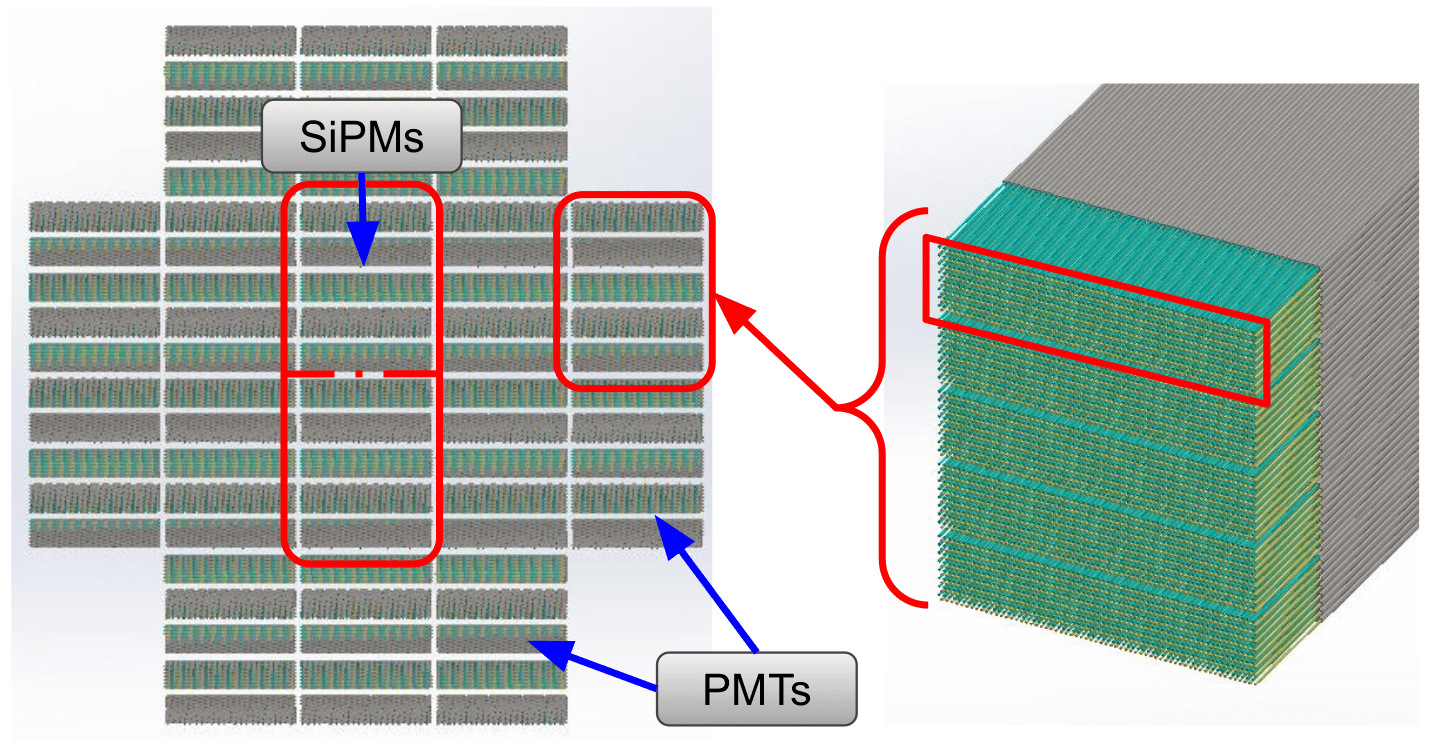

Let's start installing some libraries

Install Pytorch Geometric libraries

In [ ]:
# Install required packages.
import networkx as nx
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import random
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch_cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.0.1+cu118
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Here we load the simulated dataset:

Positively-charged pions are shot at the center of the calorimeter, where the fibers are read through SiPMs, with a calorimeter tilted by 2.5 degrees in both X and Y directions.
200 events are simulated per each energy set, with primary particle energy ranging in the values [10, 20, 30, 40, 60, 80, 100] GeV.


In [ ]:
!curl https://cernbox.cern.ch/remote.php/dav/public-files/7GrigA2KQ7uDvR4/hits_piplus_10GeV.csv -o hits_piplus_10GeV.csv
!curl https://cernbox.cern.ch/remote.php/dav/public-files/wPraydaZYzRL18I/hits_piplus_20GeV.csv -o hits_piplus_20GeV.csv
!curl https://cernbox.cern.ch/remote.php/dav/public-files/Sckke3sSgbJnZPT/hits_piplus_30GeV.csv -o hits_piplus_30GeV.csv
!curl https://cernbox.cern.ch/remote.php/dav/public-files/eGtiQK5ciKXyUTu/hits_piplus_40GeV.csv -o hits_piplus_40GeV.csv
!curl https://cernbox.cern.ch/remote.php/dav/public-files/l6o77MgGgdD0tbr/hits_piplus_60GeV.csv -o hits_piplus_60GeV.csv
!curl https://cernbox.cern.ch/remote.php/dav/public-files/TnevGLZ0Z1GawlT/hits_piplus_80GeV.csv -o hits_piplus_80GeV.csv
!curl https://cernbox.cern.ch/remote.php/dav/public-files/mPuwiJldxiIvibi/hits_piplus_100GeV.csv -o hits_piplus_100GeV.csv

!ls


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2837k  100 2837k    0     0   565k      0  0:00:05  0:00:05 --:--:--  753k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5627k  100 5627k    0     0  2450k      0  0:00:02  0:00:02 --:--:-- 2451k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 8309k  100 8309k    0     0  3850k      0  0:00:02  0:00:02 --:--:-- 3850k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.5M  100 10.5M    0     0  3128k      0  0:00:03  0:00:03 --:--:-- 3127k
  % Total    % Received % Xferd  Average Speed   Tim

Use GPU, if available, and check memory usage:

In [ ]:
def print_device_usage(device):
    tot_memory = torch.cuda.get_device_properties(device).total_memory/1024.0**3
    reserved_memory = torch.cuda.memory_reserved(device)/1024.0**3
    allocated_memory = torch.cuda.memory_allocated(device)/1024.0**3
    free_memory = reserved_memory-allocated_memory  # free inside reserved
    print('Total memory in Gb: %.2f'%tot_memory)
    print('Reserved memory in Gb: %.2f'%reserved_memory)
    print('Allocated memory in Gb: %.2f'%allocated_memory)
    print('Free memory in Gb: %.2f'%free_memory)

print(torch.__version__)
print("CUDA GPU:", torch.cuda.is_available())
#torch.manual_seed(42)
# check if a GPU is available. Otherwise run on CPU
device = 'cpu'
args_cuda = torch.cuda.is_available()
if args_cuda: device = "cuda:0"
print('device : ',device)
if args_cuda: print_device_usage(device)
torch.cuda.empty_cache()

torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)
random.seed(1)
torch.backends.cudnn.deterministic=True

2.0.1+cu118
CUDA GPU: True
device :  cuda:0
Total memory in Gb: 14.75
Reserved memory in Gb: 1.75
Allocated memory in Gb: 0.26
Free memory in Gb: 1.50


Read the text file as pandas Dataframes: each row  of these dataframes represent one simulated event. The variables are the event ID number, the truth energy we want to  reconstruct, the truth particle number  as stated by the PDG (not used here); then, there are  the calibrated energies  from Scintillating (S) and Cerenkov (C) fibers, from all the 80 PMTs of the whole calorimeter, and from the SiPMs in the ten central modules of the prototype. 'PMTenergyComb' and 'SiPMenergyComb' are the Dual-Readout corrected energies estimated by the previous described variables. Finally, 'hitsCoord' is a list of all the hits in the calorimeter belonging to the same event, and contain  the 3D coordinates (x,y,z) and the energy deposited in the hit (E).


In [ ]:
input_features = ['evtID', 'truthE', 'truthPDG','PMTenergyS', 'PMTenergyC', 'PMTenergyComb', 'SiPMenergyS', 'SiPMenergyC', 'SiPMenergyComb', 'hitsCoord']
node_features = ['PMTenergyS', 'PMTenergyC', 'PMTenergyComb', 'SiPMenergyS', 'SiPMenergyC', 'SiPMenergyComb', 'x', 'y', 'z', 'E']

myDF10 = pd.read_csv('hits_piplus_10GeV.csv', sep="\t", names=['evtID', 'truthE', 'truthPDG','PMTenergyS', 'PMTenergyC', 'PMTenergyComb', 'SiPMenergyS', 'SiPMenergyC', 'SiPMenergyComb', 'hitsCoord'])
myDF20 = pd.read_csv('hits_piplus_20GeV.csv', sep="\t", names=['evtID', 'truthE', 'truthPDG','PMTenergyS', 'PMTenergyC', 'PMTenergyComb', 'SiPMenergyS', 'SiPMenergyC', 'SiPMenergyComb', 'hitsCoord'])
myDF30 = pd.read_csv('hits_piplus_30GeV.csv', sep="\t", names=['evtID', 'truthE', 'truthPDG','PMTenergyS', 'PMTenergyC', 'PMTenergyComb', 'SiPMenergyS', 'SiPMenergyC', 'SiPMenergyComb', 'hitsCoord'])
myDF40 = pd.read_csv('hits_piplus_40GeV.csv', sep="\t", names=['evtID', 'truthE', 'truthPDG','PMTenergyS', 'PMTenergyC', 'PMTenergyComb', 'SiPMenergyS', 'SiPMenergyC', 'SiPMenergyComb', 'hitsCoord'])
myDF60 = pd.read_csv('hits_piplus_60GeV.csv', sep="\t", names=['evtID', 'truthE', 'truthPDG','PMTenergyS', 'PMTenergyC', 'PMTenergyComb', 'SiPMenergyS', 'SiPMenergyC', 'SiPMenergyComb', 'hitsCoord'])
myDF80 = pd.read_csv('hits_piplus_80GeV.csv', sep="\t", names=['evtID', 'truthE', 'truthPDG','PMTenergyS', 'PMTenergyC', 'PMTenergyComb', 'SiPMenergyS', 'SiPMenergyC', 'SiPMenergyComb', 'hitsCoord'])
myDF100 = pd.read_csv('hits_piplus_100GeV.csv', sep="\t", names=['evtID', 'truthE', 'truthPDG','PMTenergyS', 'PMTenergyC', 'PMTenergyComb', 'SiPMenergyS', 'SiPMenergyC', 'SiPMenergyComb', 'hitsCoord'])




In [ ]:
sets = [10, 20, 30, 40, 60, 80, 100]
dfs = [myDF10, myDF20, myDF30, myDF40, myDF60, myDF80, myDF100]

We can now see some of the data that are stored in the files. Considering only the energy information from the PMT, we can see that both the Scintillating and Cerenkov calibrated energy distributions are lower than the truth energy value, for each of the datasets. On the other hand, the Dual-Readout combined reconstructed energy is more or less precisely distributed around the correct energy, and out task is to shrink as possible these distributions.

[1.2663209506607405, 1.7574295437228058, 2.507398594270915, 2.5946216080817304, 3.5455927132485487, 3.738912867586079, 4.936822955572041]


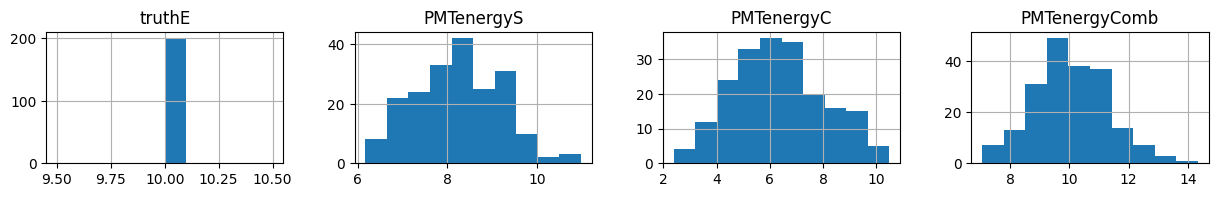

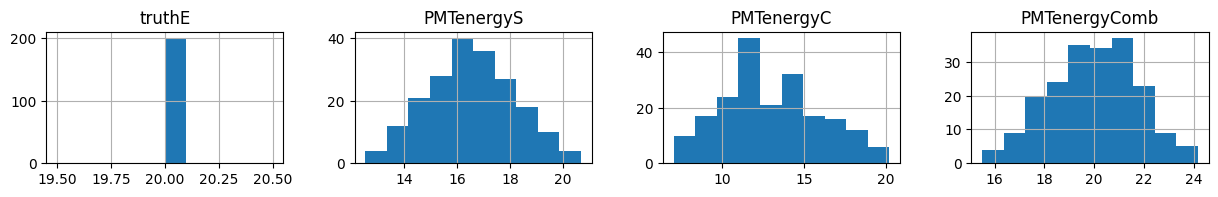

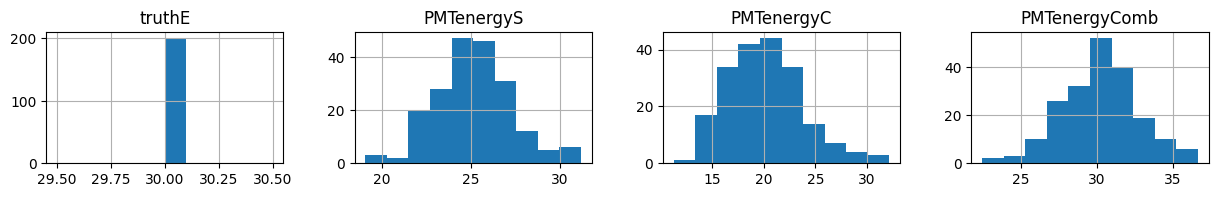

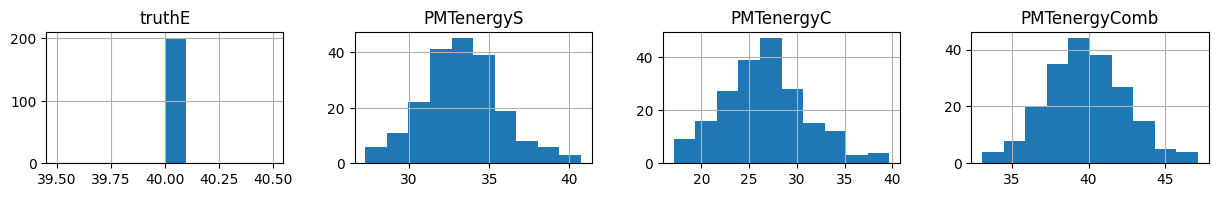

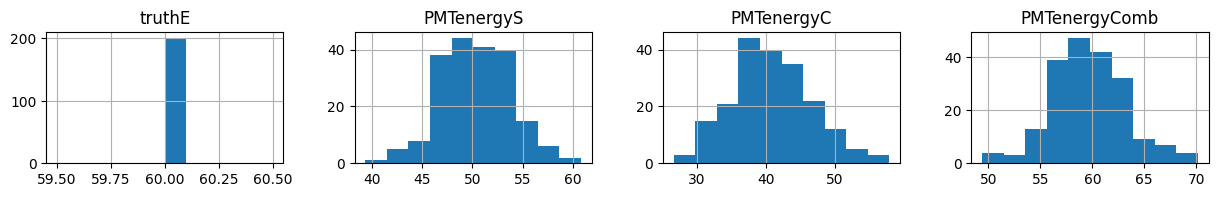

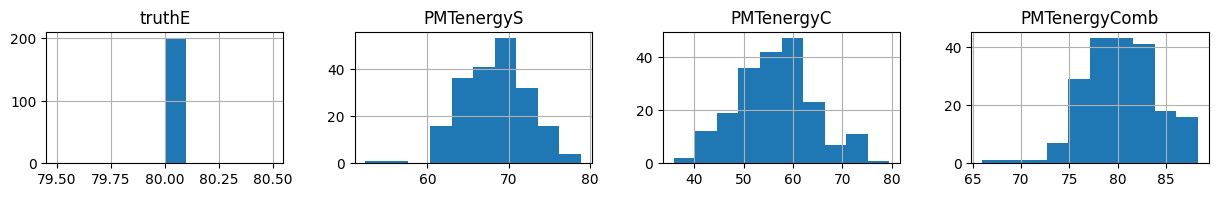

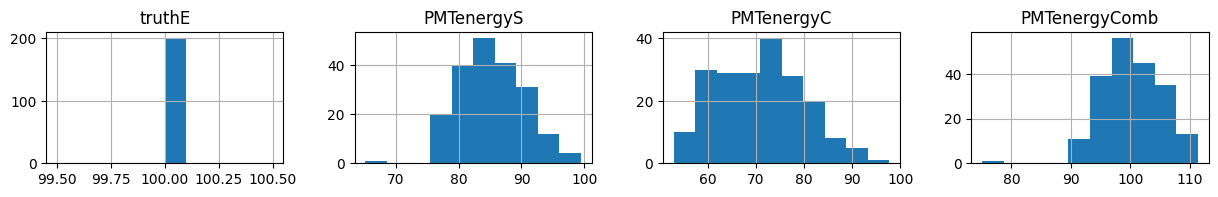

In [ ]:
DR_resolutions = []
DR_reco = []
for df in dfs:
  filter=["truthE", "PMTenergyS", "PMTenergyC", "PMTenergyComb"]
  df.hist(column=filter, bins=10, figsize=(15, 15), layout=(len(dfs), len(filter)))
  DR_resolutions.append(df["PMTenergyComb"].std())
  DR_reco.append(df["PMTenergyComb"].mean())

print(DR_resolutions)


Let's start importing the libraries for Graph NNs

In [ ]:
import torch_geometric
from torch_geometric.nn import knn_graph, EdgeConv, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv, GATv2Conv
from torch_cluster import knn_graph

Some cleanup is required to pass the given dataset to a GNN: first of all, for each event (graph) the graph-level features that will be used in the training are extended to each node.

Due to the limited resources on Colab, I tried filtering all the nodes depending on the deposited energy of the associated hit, considering only the 600 largest ones.

The result is an array of "n_events" tensors, each one representing a simulated event consisting of "n_nodes" nodes. Each node has as features the associated 3D coordinates + Hit energy, and the event reconstructed energies by the PMTs and the SiPMs, for cerernkov and scintillating fibers separately or combined through the Dual-Readout technique.



In [ ]:
from ast import literal_eval
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
def make_dataset(dataset, df, hits_column_name, target_name, input_features, node_features):
    df[hits_column_name] = df[hits_column_name].fillna("[]").apply(lambda x: eval(x))
    target = np.array(df[target_name])
    n_events = df[hits_column_name].shape[0]
    print("Number of events (Graphs): ", n_events)
    for event in range(n_events):
        # If the number of energy deposits is larger than 1000, filter only the 1000 larger ones
        n_nodes = min(np.array(df[hits_column_name][event]).shape[0], 600)
        x = np.array([   item[0] for item in  np.array(df[hits_column_name][event])   ])
        y = np.array([   item[1] for item in  np.array(df[hits_column_name][event])   ])
        z = np.array([   item[2] for item in  np.array(df[hits_column_name][event])   ])
        E = np.array([   item[3] for item in  np.array(df[hits_column_name][event])   ])
        truthE = np.full(x.shape, df.truthE[event])
        PMTenergyS = np.full(x.shape, df.PMTenergyS[event])
        PMTenergyC = np.full(x.shape, df.PMTenergyC[event])
        PMTenergyComb = np.full(x.shape, df.PMTenergyComb[event])
        SiPMenergyS = np.full(x.shape, df.SiPMenergyS[event])
        SiPMenergyC = np.full(x.shape, df.SiPMenergyC[event])
        SiPMenergyComb = np.full(x.shape, df.SiPMenergyComb[event])
        hit_data = np.stack((PMTenergyS, PMTenergyC, PMTenergyComb, SiPMenergyS, SiPMenergyC, SiPMenergyComb, x, y, z, E), axis=-1)
        eventDF = pd.DataFrame(hit_data, columns=['PMTenergyS', 'PMTenergyC', 'PMTenergyComb', 'SiPMenergyS', 'SiPMenergyC', 'SiPMenergyComb', 'x', 'y', 'z', 'E']).nlargest(n_nodes, 'E')
        d = Data(x = torch.tensor(eventDF.values, dtype=torch.float), y = torch.tensor(truthE[0], dtype=torch.float), num_nodes = n_nodes)
        dataset.append(d)


Now we join all graphs to a list, in order to have a single dataset with multiple energies

In [ ]:
hit_dataset = []
make_dataset(hit_dataset, myDF10, 'hitsCoord', 'truthE', input_features, node_features)
make_dataset(hit_dataset, myDF20, 'hitsCoord', 'truthE', input_features, node_features)
make_dataset(hit_dataset, myDF30, 'hitsCoord', 'truthE', input_features, node_features)
make_dataset(hit_dataset, myDF40, 'hitsCoord', 'truthE', input_features, node_features)
make_dataset(hit_dataset, myDF60, 'hitsCoord', 'truthE', input_features, node_features)
make_dataset(hit_dataset, myDF80, 'hitsCoord', 'truthE', input_features, node_features)
make_dataset(hit_dataset, myDF100, 'hitsCoord', 'truthE', input_features, node_features)



Number of events (Graphs):  200
Number of events (Graphs):  200
Number of events (Graphs):  200
Number of events (Graphs):  200
Number of events (Graphs):  200
Number of events (Graphs):  200


We can now proceed with splitting the whole dataset in a training and a validation sample, using the torch geometric DataLoader function for the batch production.

The batch size was reduced to not overload the GPU.

In [ ]:
from sklearn.model_selection import train_test_split
dataset_size = len(hit_dataset)
val_split = 0.2
val_size = int(val_split * dataset_size)
train_size = dataset_size - val_size
hit_dataset_train, hit_dataset_val = train_test_split(hit_dataset, test_size = val_size, train_size = train_size, shuffle=True)

batch_size = 16
hit_loader_train = DataLoader(hit_dataset_train, batch_size=batch_size, shuffle=True)
hit_loader_val = DataLoader(hit_dataset_val, batch_size=batch_size, shuffle=True)
for data in hit_loader_val:
    print(data)
    print(data.batch)
    break


We can now start with the implementation of the Particle-Net like GNN:

The overall layout is almost identical to the original one, where only the softmax function in the last layer was removed to perform a regression task instead of classification, and a fully-connected layer was added to try achieving better performances.


In [ ]:
features_to_consider = 'PMTenergyS,PMTenergyC,PMTenergyComb,SiPMenergyS,SiPMenergyC,SiPMenergyComb,x,y,z,E'.split(',')


class ParticleNetEdgeNet(nn.Module):
    def __init__(self, in_size, layer_size):
        super(ParticleNetEdgeNet, self).__init__()

        layers = []
        layers.append(nn.Linear(in_size*2, layer_size))           # directed Graph
        layers.append(nn.BatchNorm1d(layer_size))
        layers.append(nn.ReLU())

        for i in range(2):
            layers.append(nn.Linear(layer_size, layer_size))
            layers.append(nn.BatchNorm1d(layer_size))
            layers.append(nn.ReLU())

        self.model = nn.Sequential(*layers)


    def forward(self, x):
        return self.model(x)

    def __repr__(self):
        return "{}(nn={})".format(self.__class__.__name__, self.model)



Here only a very limited fine-tuning has been realized: Google Colab often limited the access to GPUs, so I had to reduce the batch size and the number of neurons with respect to the version I was running on a local workstation.

In [ ]:
class ParticleNet(nn.Module):
    def __init__(self, node_feat_size, num_classes=1):
        super(ParticleNet, self).__init__()
        self.node_feat_size = node_feat_size
        self.num_classes = num_classes

        self.k = 8  #8                                            # K  number of connections to closest nodes in KNN cluster neighbor
        self.num_edge_convs = 3                     # number of stacked EdgeConv blocks
        #self.kernel_sizes = [64, 128, 256]          # number of units in three linear transformation layers in EdgeConv blocks
        self.kernel_sizes = [32, 64, 128]          # number of units in three linear transformation layers in EdgeConv blocks
        self.fc_size = 128                          # units  in the first fully-connected layer after EdgeConv blocks
        self.dropout = 0.1
        self.edge_nets = nn.ModuleList()
        self.edge_convs = nn.ModuleList()

        self.kernel_sizes.insert(0, self.node_feat_size)
        self.output_sizes = np.cumsum(self.kernel_sizes)        # inputs also include previous layer output

        # first EdgeConv block
        self.edge_nets.append(ParticleNetEdgeNet(self.node_feat_size, self.kernel_sizes[1]))
        self.edge_convs.append(EdgeConv(self.edge_nets[-1], aggr="mean"))

        # stack other EdgeConv blocks on the first
        for i in range(1, self.num_edge_convs):
            print("self.num_edge_convs", i)
            # add kernel sizes because of skip connections
            self.edge_nets.append( ParticleNetEdgeNet(self.output_sizes[i], self.kernel_sizes[i+1]) )
            self.edge_convs.append(EdgeConv(self.edge_nets[-1], aggr="mean"))

        self.fc1 = nn.Sequential(nn.Linear(self.output_sizes[-1], self.fc_size))
        self.drouput_layer = nn.Dropout(p=self.dropout)
        self.fc2 = nn.Linear(self.fc_size, self.fc_size)
        self.drouput_layer = nn.Dropout(p=self.dropout)
        self.fc3 = nn.Linear(self.fc_size, self.num_classes)



    def forward(self, data):
        x = data.x
        batch = data.batch
        for i in range(self.num_edge_convs):
            edge_index = ( knn_graph(x[:, 6:9], self.k, batch) if i==0 else knn_graph(x, self.k, batch) )
            x = torch.cat( (self.edge_convs[i](x, edge_index), x), dim=1 )  # concatenating with original features i.e. skip connection
        x = global_mean_pool(x, batch)
        x = self.fc1(x)
        x = self.fc2(x)

        return self.fc3(x)





In [ ]:
def gnn_model_summary(model):
    model_params_list = list(model.named_parameters())
    print("----------------------------------------------------------------")
    line_new = "{:>20}  {:>25} {:>15}".format("Layer.Parameter", "Param Tensor Shape", "Param #")
    print(line_new)
    print("----------------------------------------------------------------")
    for elem in model_params_list:
        p_name = elem[0]
        p_shape = list(elem[1].size())
        p_count = torch.tensor(elem[1].size()).prod().item()
        line_new = "{:>20}  {:>25} {:>15}".format(p_name, str(p_shape), str(p_count))
        print(line_new)
    print("----------------------------------------------------------------")
    total_params = sum([param.nelement() for param in model.parameters()])
    print("Total params:", total_params)
    num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Trainable params:", num_trainable_params)
    print("Non-trainable params:", total_params - num_trainable_params)


In [ ]:
def train_test_one_epoch(model,jets_loader, device, optimizer, loss_fn, batch_size, history, mode='train'):
    if mode=='train':
        model.train(True)
    else:
        model.train(False)

    running_loss, running_correct = 0.,0.
    tot_iter = len(jets_loader)
    t = tqdm.tqdm(enumerate(jets_loader),total=tot_iter)
    for i, data in t:
        inputs = data # For the inputs we are passing the whole Data() object
        labels = data.y.unsqueeze(1)
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad() # Clear gradients
        outputs = model(inputs) # Perform a single forward pass
        loss = loss_fn(outputs, labels) # Compute the loss
        if mode=='train':
            loss.backward()  # Derive gradients
            optimizer.step() # Update parameters based on gradients.

        running_loss += loss.item() #.item() returns average loss over the batch
        del loss



    epoch_loss = running_loss / tot_iter
    history.append( running_loss/tot_iter)

    return epoch_loss, outputs



Tried to use the Huber Loss cost function instead of the mean squared errors to reduce the effect of outliers (mostly particles which escaped from the calorimeter without being absorbed)

Start the training and save the model with best parameters

In [ ]:
import torch.optim as optim
import tqdm


gnn = ParticleNet(node_feat_size=len(features_to_consider), num_classes=1)
gnn.to(device)
#loss_fn = torch.nn.MSELoss()                            # Using Mean Squared Error as loss function for regression
loss_fn = torch.nn.HuberLoss()

optimizer = optim.Adam(gnn.parameters(), lr = 0.001)
EPOCHS = 20
loss_train, loss_val = [],[]
acc_train, acc_val = [],[]
gnn_model_summary(gnn)
print(hit_dataset_val[:10])

history_train = []
history_val = []
for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch + 1))

    loss_train_epoch,  y_pred_train = train_test_one_epoch(gnn, hit_loader_train, device, optimizer, loss_fn, batch_size, history_train, mode = 'train')
    loss_val_epoch, y_pred_val = train_test_one_epoch(gnn, hit_loader_val, device, optimizer, loss_fn, batch_size, history_val, mode = 'test')
    print('LOSS train {:.3f}, valid {:.3f}'.format(loss_train_epoch, loss_val_epoch))
    loss_train.append(loss_train_epoch)
    loss_val.append(loss_val_epoch)
    #save model state with best parameters
    torch.save(gnn.state_dict(), 'best-model-parameters.pt')


In [ ]:
best_model_param = torch.load('best-model-parameters.pt')
gnn.load_state_dict(best_model_param)

Now I separate events in the validation set depending on the truth energy, in order to check the distributions of the reconstructed energies per each truth value

In [ ]:
pred_energy = []
truth_energy = []
pred_label = []
true_label = []
for i, data in enumerate(hit_loader_val):
    inputs, truth = data, data.y
    outData = data.x.cpu().detach().numpy()
    y_true = data.y.cpu().detach().numpy()

    inputs = inputs.to(device)
    y_pred = gnn(inputs.to(device)).cpu().detach().numpy().squeeze(1)
    truth_energy.append(y_true)
    pred_energy.append(y_pred)


In [ ]:
def split_iterate(df, colname):
    return [x for __, x in df.groupby(colname)]


truth_energy = np.concatenate(truth_energy).ravel()
pred_energy = np.concatenate(pred_energy).ravel()
gnnRecoDF = pd.DataFrame({'TruthEnergy' : truth_energy, 'GNNenergy' : pred_energy})

print(gnnRecoDF)
results_array = split_iterate(gnnRecoDF, 'TruthEnergy')




Finally, a little data analysis:

Per each energy set between 10 and 100 GeV, the distributions of the reconstructed energies are plotted, and should have a peak close to the truth value. These plots should be compared to the 'PMTenergyComb' that was shown at the beginning, where only Dual-Readout corrected energy was plotted.

The RMS of the GNN output  distributions are plotted and a linear fit is then compared to the one collected through the raw dual readout data, to evaluate the calorimeter resolution. The lower is the stochastic term, the better is the performance.


In [ ]:
import scipy
resolution = []
fit_resolution = []
fit_Epeak = []
energies = []
for i in range(len(results_array)):
    trueE = int(results_array[i].TruthEnergy.mean())
    recoE = results_array[i].GNNenergy.mean()
    recoE_std = results_array[i].GNNenergy.std()
    resolution.append(recoE_std/trueE)
    energies.append(trueE)
    bmin = trueE - 3*np.sqrt(trueE)
    bmax = trueE + 3*np.sqrt(trueE)
    myBins = np.linspace(bmin, bmax, 100)
    counts, bins = np.histogram(results_array[i].GNNenergy, bins=100, range=(bmin, bmax))
    plt.hist(results_array[i].GNNenergy, bins=15, range=(bmin, bmax), density=1)
    plt.xlabel('Energy [GeV]')

    mu, sigma = scipy.stats.norm.fit(results_array[i].GNNenergy)
    best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
    fit_resolution.append(sigma)
    fit_Epeak.append(mu)

    plt.plot(bins, best_fit_line)

    plt.show()
    plt.clf()



energies = np.array(energies)
x = 1/np.sqrt(energies)
y = np.array(fit_resolution)/np.array(fit_Epeak)
coef = np.polyfit(x, y, 1)
polyf = np.poly1d(coef)
plt.plot(x, y, 'o', x, polyf(x), label="GNN", color='red')
print("\nGNN resolution: ", coef[0]*100, "%/sqrt(E) + ", coef[1]*100)

yDR = np.array(DR_resolutions)/np.array(DR_reco)
DRcoef = np.polyfit(x, yDR, 1)
DRpolyf = np.poly1d(DRcoef)
plt.plot(x, yDR, 'o', x, DRpolyf(x), label="DR only", color='navy')
print("HiDRa Raw resolution: ", DRcoef[0]*100, "%/sqrt(E) + ", DRcoef[1]*100)
plt.legend()
plt.xlabel(r'1/$\sqrt{E}$ [GeV]$^{-1/2}$')
plt.ylabel(r"$\sigma$(E)/E")
plt.show()


Due to the limited amount of data in the validation set, the errors were not added in the plot.

As a comparison, here is a preliminary result plot from the actual prototype studies, where 10000 events were simulated per each energy value, for two different absorber materials. (Steel absorber was used in the simulations for the present notebook)

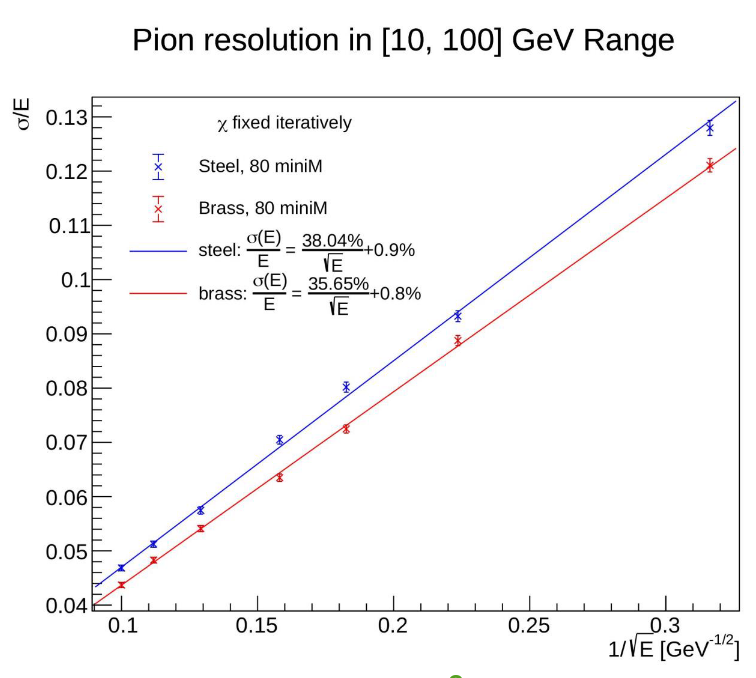